In [415]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,classification_report,
    confusion_matrix, roc_curve, auc
)
#xgboost
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.feature_selection import RFE
#chi2
from sklearn.feature_selection import chi2
# Decision Tree 
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import RocCurveDisplay
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [416]:
# Step 1: Load and examine the data
# Load the dataset
df = pd.read_csv('heart_disease_uci.csv')
df_model = df.copy()

# Display basic information about the dataset
print("Dataset Shape:", df_model.shape)
print("\nBasic Information about the dataset:")
df_model.info()

# Display the first few rows
print("\nFirst few rows of the dataset:")
display(df_model.head())

# Check for missing values
print("\nMissing values in each column:")
missing_values = df_model.isnull().sum()
missing_percentages = (missing_values / len(df_model)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
})
print(missing_info[missing_info['Missing Values'] > 0])

Dataset Shape: (920, 16)

Basic Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

First few rows of the dataset:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



Missing values in each column:
          Missing Values  Percentage
trestbps              59    6.413043
chol                  30    3.260870
fbs                   90    9.782609
restecg                2    0.217391
thalch                55    5.978261
exang                 55    5.978261
oldpeak               62    6.739130
slope                309   33.586957
ca                   611   66.413043
thal                 486   52.826087


In [417]:
#drop dataset and id column
df_model.drop(columns=['id', 'dataset'], axis=1, inplace=True)

In [418]:
categorical_columns = [col for col in df_model.columns if df_model[col].dtype in ['object', 'category']]
numeric_columns = [col for col in df_model.columns if df_model[col].dtype in ['int64', 'float64']]

print(numeric_columns)
print(categorical_columns)
for col in categorical_columns:
  print(f"The Unique Values In {col} = {df_model[col].unique()}")

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
The Unique Values In sex = ['Male' 'Female']
The Unique Values In cp = ['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
The Unique Values In fbs = [True False nan]
The Unique Values In restecg = ['lv hypertrophy' 'normal' 'st-t abnormality' nan]
The Unique Values In exang = [False True nan]
The Unique Values In slope = ['downsloping' 'flat' 'upsloping' nan]
The Unique Values In thal = ['fixed defect' 'normal' 'reversable defect' nan]


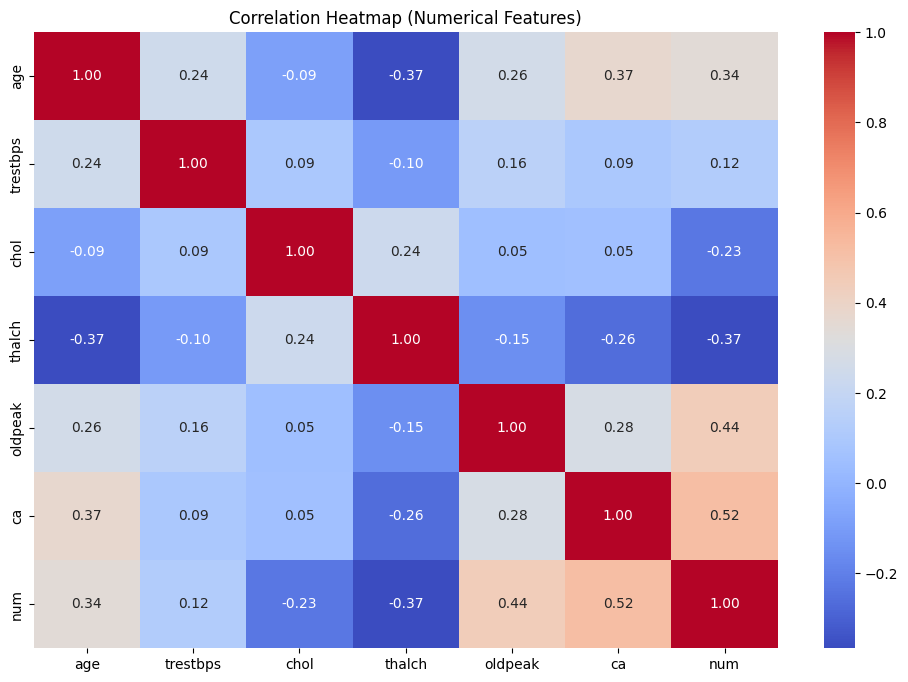


Correlation Ratio for Categorical Features:
   Feature  Correlation_Ratio
1       cp           0.447646
4    exang           0.372757
6     thal           0.329838
5    slope           0.286781
0      sex           0.259342
3  restecg           0.172629
2      fbs           0.153581


In [419]:
# 3.2 Correlation Analysis
# ---------------------------

# Numerical correlations (Pearson)
numerical_cols = df_model.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

# Categorical correlations using Correlation Ratio (Eta)
categorical_cols = df_model.select_dtypes(include=['object']).columns
eta_results = {}

for col in categorical_cols:
    fcat, _ = pd.factorize(df_model[col])
    cat_num = np.max(fcat) + 1
    values = df_model['num'].values
    y_avg = np.mean(values)
    
    numerator = 0
    denominator = np.sum((values - y_avg) ** 2)
    
    for i in range(cat_num):
        yi = values[np.argwhere(fcat == i).flatten()]
        ni = len(yi)
        numerator += ni * (np.mean(yi) - y_avg) ** 2
    
    eta = np.sqrt(numerator / denominator)
    eta_results[col] = eta

eta_df = pd.DataFrame(list(eta_results.items()), columns=['Feature', 'Correlation_Ratio'])
print("\nCorrelation Ratio for Categorical Features:")
print(eta_df.sort_values(by='Correlation_Ratio', ascending=False))


In [420]:
# 1. Copy the original DataFrame
df_temp = df_model.copy()

# ---------------------------
# 2. Handle numerical columns using median
numerical_columns = ['trestbps','chol', 'thalch', 'oldpeak']
for col in numerical_columns:
    df_temp[col].fillna(df_temp[col].median(), inplace=True)

# ---------------------------
# 3. Handle categorical columns using mode
categorical_columns = ['restecg', 'fbs', 'exang']
for col in categorical_columns:
    df_temp[col].fillna(df_temp[col].mode()[0], inplace=True)

# ---------------------------
# 4. Handle 'ca' column using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_temp[['ca']] = imputer.fit_transform(df_temp[['ca']])

# ---------------------------
# 5. Encode categorical columns to numeric using LabelEncoder
le_dict = {}
for col in df_temp.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_temp[col] = le.fit_transform(df_temp[col].astype(str))
    le_dict[col] = le

# ---------------------------
# 6. RandomForest imputation for 'slope' and 'thal'
label_cols = ['slope', 'thal']

for target_col in label_cols:
    missing_idx = df_temp[target_col].isna()
    n_missing = missing_idx.sum()
    print(f"Missing values in {target_col}: {n_missing}")
    
    if n_missing == 0:
        continue
    
    features = df_temp.drop(columns=['num'] + label_cols)
    target = df_temp[target_col]
    
    X_train = features[~missing_idx]
    y_train = target[~missing_idx]
    X_missing = features[missing_idx]
    
    # Detect model type based on data type
    if y_train.dtype == 'object' or y_train.nunique() < 20:
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(random_state=42)
    else:
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_missing)
    
    # Fill missing values
    df_temp.loc[missing_idx, target_col] = y_pred
    print(f"Filled {n_missing} missing values in {target_col}")

# ---------------------------
# 7. Update the original DataFrame after imputation
df_model = df_temp.copy()

# ---------------------------
# 8. Check for missing values after imputation
print("\nMissing values after imputation:")
print(df_model.isnull().sum())

Missing values in slope: 0
Missing values in thal: 0

Missing values after imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [421]:
df_model['num'] = df_model['num'].apply(lambda x: 1 if x > 0 else 0)
# 3. One-hot encoding for categorical variables
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

In [422]:
#split the data into training and testing sets
X = df_model.drop('num', axis=1)        
y = df_model['num']


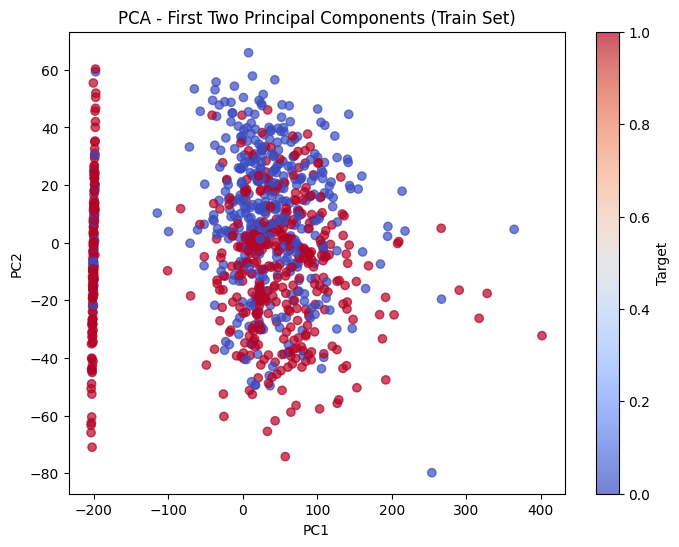

In [423]:
 #4️⃣ PCA (retain 95% variance)
# ---------------------------

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)
# ---------------------------
# 5️⃣ Optional: Visualize first two PCs
# ---------------------------

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - First Two Principal Components (Train Set)')
plt.colorbar(label='Target')
plt.show()

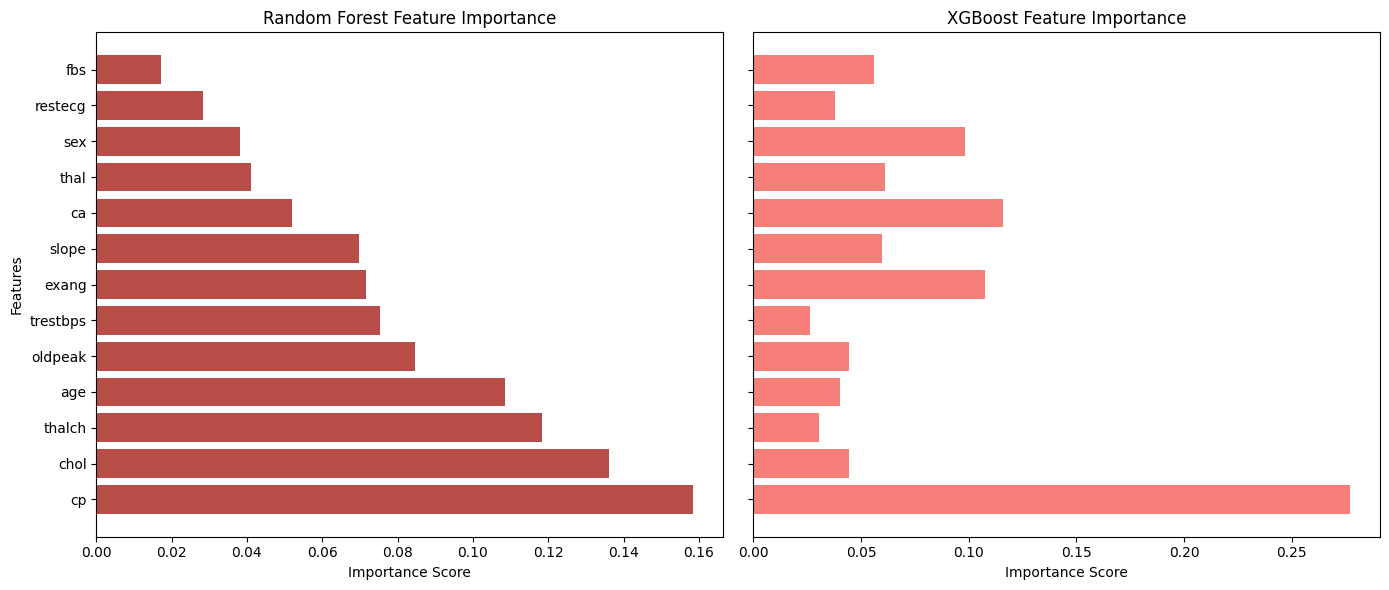

In [424]:
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Fit Random Forest
rf_model.fit(X, y)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf_model.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

# Fit XGBoost
xgb_model.fit(X, y)
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'XGB_Importance': xgb_model.feature_importances_
}).sort_values(by='XGB_Importance', ascending=False)

# Step 2: Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Random Forest
ax1.barh(rf_importance['Feature'], rf_importance['RF_Importance'], color='#b94d48')
ax1.set_title('Random Forest Feature Importance')
ax1.set_xlabel('Importance Score')
ax1.set_ylabel('Features')
ax1.invert_yaxis()  # Show most important at the top

# XGBoost
ax2.barh(xgb_importance['Feature'], xgb_importance['XGB_Importance'], color='#f67f79')
ax2.set_title('XGBoost Feature Importance')
ax2.set_xlabel('Importance Score')
ax2.invert_yaxis()  # Show most important at the top

plt.tight_layout()
plt.show()



In [425]:

rfe = RFE(estimator=rf_model, n_features_to_select=6)  # Selecting top 6 features
rfe.fit(X, y)
rfe_selected = X.columns[rfe.support_].tolist()

In [426]:
X=abs(X)
chi2_scores, p_values = chi2(X, y)
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': p_values
}).sort_values(by='Chi2_Score', ascending=False)
     

In [427]:
significant_features = chi2_results[chi2_results['P_Value'] < 0.05]['Feature'].tolist()

In [428]:

print("Random Forest Feature Importance:")
print(rf_importance)
print("\nXGBoost Feature Importance:")
print(xgb_importance)
print("\nRFE Selected Features:")
print(rfe_selected)
print("\nChi-Square Test Results:")
print(chi2_results)
print("\nSignificant Features (p < 0.05):")
print(significant_features)

Random Forest Feature Importance:
     Feature  RF_Importance
2         cp       0.158491
4       chol       0.136226
7     thalch       0.118447
0        age       0.108646
9    oldpeak       0.084696
3   trestbps       0.075324
8      exang       0.071729
10     slope       0.069770
11        ca       0.052093
12      thal       0.040984
1        sex       0.038084
6    restecg       0.028289
5        fbs       0.017221

XGBoost Feature Importance:
     Feature  XGB_Importance
2         cp        0.277162
11        ca        0.115887
8      exang        0.107762
1        sex        0.098428
12      thal        0.061338
10     slope        0.059739
5        fbs        0.056158
9    oldpeak        0.044481
4       chol        0.044284
0        age        0.040306
6    restecg        0.037710
7     thalch        0.030477
3   trestbps        0.026269

RFE Selected Features:
['age', 'cp', 'trestbps', 'chol', 'thalch', 'oldpeak']

Chi-Square Test Results:
     Feature   Chi2_Score        P

In [429]:
relevant_features = list(set(rfe_selected) & set(significant_features))
print("\nMost Relevant Features for Modeling:")
print(relevant_features)


Most Relevant Features for Modeling:
['trestbps', 'age', 'cp', 'thalch', 'oldpeak', 'chol']


In [430]:
X=X[relevant_features]
Y=y
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
#smote = SMOTE(random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
# 6️⃣ Scale features
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

In [431]:

# 4️⃣ Initialize all models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 5️⃣ Train, Evaluate and Plot
results = {}
plt.figure(figsize=(10, 7))

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Scale only for models sensitive to scaling
    if name in ["Logistic Regression", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train_sm)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train_scaled, y_train_sm)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}
    
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))


--- Training Logistic Regression ---
Accuracy: 0.7989
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78        82
           1       0.84      0.79      0.81       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184


--- Training KNN ---
Accuracy: 0.7772
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75        82
           1       0.79      0.81      0.80       102

    accuracy                           0.78       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.78      0.78      0.78       184


--- Training Decision Tree ---
Accuracy: 0.7011
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68        82
           1       0.7

<Figure size 1000x700 with 0 Axes>

In [432]:


# ---------------------------
# 1️⃣ Define models and hyperparameter grids
# ---------------------------
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=500, random_state=42),
        "grid": {"C": [0.01, 0.1, 1, 10]},
        "random": {"C": [0.01, 0.1, 1, 10]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "grid": {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]},
        "random": {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "grid": {"n_estimators": [100, 200], "max_depth": [10, 20, 30]},
        "random": {"n_estimators": [50, 100, 150, 200], "max_depth": [5, 10, 20, 30]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        "grid": {"n_estimators": [10, 50], "max_depth": [3, 6], "learning_rate": [0.05, 0.1]},
        "random": {"n_estimators": [10, 50, 100], "max_depth": [3, 6, 10], "learning_rate": [0.01, 0.05, 0.1]}
    }
}

# ---------------------------
# 2️⃣ Cross-validation setup
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
best_models = {}

# ---------------------------
# 3️⃣ Loop over models
# ---------------------------
for name, cfg in param_grids.items():
    print(f"\n=== {name} ===")
    
    # Randomized Search CV
    random_search = RandomizedSearchCV(cfg["model"], cfg["random"], n_iter=5, cv=cv, scoring="accuracy", n_jobs=-1, random_state=42)
    random_search.fit(X_train_scaled, y_train_sm)
    print(" RandomizedSearchCV best params:", random_search.best_params_)
    
    # Grid Search CV
    grid_search = GridSearchCV(cfg["model"], cfg["grid"], cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_sm)
    print(" GridSearchCV best params:", grid_search.best_params_)
    
    # Choose best estimator (from Grid Search)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f" Test Accuracy: {acc:.4f}")
    print(" Classification Report:\n", classification_report(y_test, y_pred))

# ---------------------------
# 4️⃣ Final comparison
# ---------------------------
print("\n=== Final Accuracy Comparison ===")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")



=== Logistic Regression ===


 RandomizedSearchCV best params: {'C': 0.01}
 GridSearchCV best params: {'C': 0.01}
 Test Accuracy: 0.7935
 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78        82
           1       0.83      0.78      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.79      0.79       184


=== KNN ===
 RandomizedSearchCV best params: {'weights': 'distance', 'n_neighbors': 7}
 GridSearchCV best params: {'n_neighbors': 7, 'weights': 'distance'}
 Test Accuracy: 0.7880
 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76        82
           1       0.81      0.81      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.78      0.79       184
weighted avg       0.79      0.79      0.79       184


=== Rand